# Imports & Loading corpus

In [1]:
import json
import bz2
import re
from bz2 import BZ2File
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook')
sns.set(rc = {'figure.figsize':(10,7)})

In [2]:
df_corpus = pd.read_json('corpus.json.bz2', compression = 'bz2')
df_corpus_OPEP = pd.read_json('corpus_OPEP.json.bz2', compression = 'bz2')
df_corpus_petrole = pd.read_json('corpus_petrole.json.bz2', compression = 'bz2')
df_corpus_compagnies = pd.read_json('corpus_compagnies.json.bz2', compression = 'bz2')
df_depeches = pd.read_json('corpus_depeches.json.bz2', compression = 'bz2')
df_not_depeches = pd.read_json('corpus_not_depeches.json.bz2', compression = 'bz2')

In [3]:
df_corpus['journal'] = df_corpus['journal'].astype('category')
df_corpus_OPEP['journal'] = df_corpus_OPEP['journal'].astype('category')
df_corpus_petrole['journal'] = df_corpus_petrole['journal'].astype('category')
df_corpus_compagnies['journal'] = df_corpus_compagnies['journal'].astype('category')

df_corpus.index = np.arange(len(df_corpus))
df_corpus_OPEP.index = np.arange(len(df_corpus_OPEP))
df_corpus_petrole.index = np.arange(len(df_corpus_petrole))
df_corpus_compagnies.index = np.arange(len(df_corpus_compagnies))

In [4]:
df_total = pd.read_json('total.json.bz2', compression = 'bz2')
df_total['journal'] = df_total['journal'].astype('category')
df_total.index = np.arange(len(df_total))

In [32]:
df_corpus.head()

,journal,date,page,ppage,text,length,keyword_volvo,keyword_nyse,keyword_nestlé,keyword_heineken,...,keyword_ats,keyword_afp,keyword_reuter,keyword_reuther,keywords_petrole,keywords_OPEP,keywords_compagnies,keywords,depeches,year
0,JDG,1974-01-07,2,NaN,"Pétrole : "" (déjà 50000 la crise continue chôm...",3465,0,0,0,0,...,2,1,0,0,6,5,0,11,3,1974
1,JDG,1974-01-07,2,NaN,''« Je vendrai'Le chah d Iran : de l aspirine ...,1976,0,0,0,0,...,0,1,0,0,7,0,0,7,1,1974
2,JDG,1974-10-21,5,NaN,ETRANGER-DIAGNOSTIC Iran-Irak : un vieux confl...,2484,0,0,0,0,...,3,0,0,0,2,0,0,2,3,1974
3,JDG,1974-08-21,9,NaN,Du nouveau sous le soleil Nous pouvons remerci...,5930,0,0,0,0,...,4,0,0,0,4,0,0,4,4,1974
4,JDG,1974-08-28,5,NaN,Investissements étrangers aux USA : + 20 % en ...,1712,0,0,0,0,...,3,1,0,0,3,0,0,3,4,1974


# Type-token ratio analysis

In [5]:
def count_words(text):
    ''' Returns the word (i.e. type) count for a given text.
    
    Input:
        text(str)
    
    Output:
        count_words(pandas DataFrame): return the count for each word
    '''
        
    words = re.split('[\s\.,·:;\'—«»*]', text)
    count_words = pd.Series(words).value_counts()
    
    count_words = pd.DataFrame(count_words).rename(columns = {0:'count'})
    
    length = []
    
    for word in count_words.index:
        length.append(len(word))
        
    count_words['length'] = length
    
    return count_words

In [6]:
def type_token_ratio(text, n_sample = 100, tokens = 1000):
    ''' Compute the type-token ratio (TTK) of a text, on n samples of same token length.
    
    Inputs:
        text(str): text/corpus
        n_sample(int): number of repeated measures
        tokens(int): number of tokens (words) of each TTK measure
    
    Output:
        type_token_ratio(list<float>): list of the TTK measures
    '''
    
    words_ = re.split('[\s\.,·:;\'—«»*]', str(text))
    words, type_token_ratio = [], []
    
    for word_ in words_:
        if word_ != '':
            words.append(word_)
        
    distribution = np.random.uniform(0, len(words) - tokens, n_sample).astype('int')
    
    for random in distribution :
        
        range_ = words[random:random + tokens]
        
        sample = ''
        for word in range_:
            sample += word + ' '
        
        type_ = len(count_words(sample)) - 1
        type_token_ratio.append(type_ / tokens)
        
    return type_token_ratio
    

Create sub-corpora with annual granularity

In [7]:
corpus_text = ''

for ind, row in df_corpus.iterrows():
    corpus_text += row['text']

In [8]:
len(corpus_text)

68571621

In [9]:
total_text = ''

for ind, row in df_total.iterrows():
    total_text += row['text']

In [10]:
len(total_text)

1005319864

In [11]:
distribution = np.random.uniform(0, len(total_text) - 50000, 1000).astype('int')
total_text_sample = ''

for i in distribution :
    total_text_sample += total_text[i:i+50000] + ' '

In [12]:
len(total_text_sample)

50001000

In [18]:
TTR_corpus = type_token_ratio(corpus_text, n_sample = 1000, tokens = 500)
TTR_total = type_token_ratio(total_text_sample, n_sample = 1000, tokens = 500)

In [19]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("ticks")

In [ ]:
plt.boxplot([TTR_corpus, TTR_total], notch = True);

plt.xticks([1,2], np.array(['Corpus', 'Total archive']))
plt.ylabel('TTR');
plt.ylim((0.40,0.75))
plt.title('Type Token Ratio Corpus vs Total archive \s');
plt.show()

In [16]:
df_corpus['year'] = 0

for ind, row in df_corpus.iterrows():
    df_corpus['year'][ind] = row['date'].year

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [17]:
years = df_corpus['year'].value_counts().index.sort_values(ascending = True)

In [24]:
TTR_by_year = []

for year in years:
    df = df_corpus[df_corpus['year'] == year]
    
    text_year = ''
    
    for ind, row in df.iterrows():
        text_year += row['text']
        
    TTR_by_year.append(type_token_ratio(text_year, n_sample = 1000, tokens = 500))

In [26]:
np.arange(4)

array([0, 1, 2, 3])

In [ ]:
plt.boxplot(TTR_by_year, notch = True);

plt.xticks(np.arange(len(TTR_by_year))+1, years)
plt.ylabel('TTR');
plt.ylim((0.40,0.75))
plt.title('Type Token Ratio du corpus, par année \n');
plt.show()

In [31]:
for year in years:
    
    df = df_corpus[df_corpus['year'] == year]
    df.to_csv(str(year) + '_corpus.csv')

In [50]:
pages = [5, 7, 3, 9, 1]

TTR_pages = []

for page in pages:
    df = df_corpus[df_corpus['page'] == page]
    text = ''
    
    for ind, row in df.iterrows():
        text += row['text']
        
    TTR_pages.append(type_token_ratio(text, n_sample = 1000, tokens = 500))
    
    df.to_csv('corpus_page_' + str(page) + '.csv')

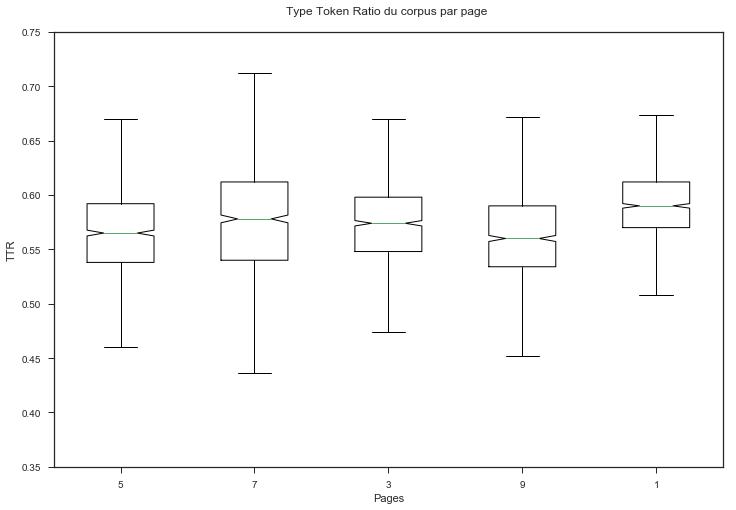

In [52]:
plt.boxplot(TTR_pages, notch = True);

plt.xticks(np.arange(len(TTR_pages))+1, pages)
plt.ylabel('TTR')
plt.xlabel('Pages')
plt.ylim((0.35,0.75))
plt.title('Type Token Ratio du corpus par page \n');
plt.show()